In [504]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [505]:
df = pd.read_csv('layoffs.csv')
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Ola,Bengaluru,Transportation,200.0,NaN,2023-01-13,Series J,India,5000.0
1,Definitive Healthcare,Boston,Healthcare,55.0,0.06,2023-01-12,IPO,United States,NaN
2,SmartNews,Tokyo,Media,120.0,0.13,2023-01-12,Series F,United States,410.0
3,Lending Club,SF Bay Area,Finance,225.0,0.14,2023-01-12,IPO,United States,392.0
4,Life360,SF Bay Area,Consumer,NaN,0.14,2023-01-12,IPO,United States,158.0


In [506]:
df.shape

(1946, 9)

In [507]:
df.describe()

,total_laid_off,percentage_laid_off,funds_raised
count,1350.000000,1315.000000,1796.000000
mean,202.960741,0.268337,842.108739
std,620.859658,0.260043,6060.030270
min,3.000000,0.000000,0.000000
25%,34.000000,0.100000,46.000000
50%,70.000000,0.180000,145.000000
75%,150.000000,0.300000,409.000000
max,11000.000000,1.000000,121900.000000


Analizando las primeras líneas del dataset, podemos extraer rápidamente las siguientes conclusiones:

- El lenguaje del dataset es inglés y las fechas están expresadas en el formato AAAA-MM-DD
- El número de empleados afectados por el despido es un valor decimal, lo cual es incorrecto dado que las personas se deben contar con enteros.
- Los porcentajes están expresados como un valor decimal entre 0 y 1, e incluyen valores nulos o desconocidos.
- Los fondos utilizados para llevar a cabo el despido están expresados como un número decimal, aunque todo indica en que los importes no los contienen

También hemos podido verificar que el dataset tiene un total de 1946 entradas, es decir, despidos. Este dato es importante para analizar la calidad de los datos y tomar decisiones sobre las correcciones a aplicar en función del error.

Tras cargar los datos del dataset, pasaremos a comprobar la calidad de los mismos, buscando valores nulos, erróneos y outliers.

En primer lugar, analizamos los valores nulos.

In [508]:
df.isnull().sum()

company                  0
location                 0
industry                 0
total_laid_off         596
percentage_laid_off    631
date                     1
stage                    4
country                  0
funds_raised           150
dtype: int64

Podemos ver que tenemos un problema considerable con los valores que miden los despidos: personas afectadas, porcentaje de afectados sobre el total de empleados y, en menor medida, el importe total necesario para llevar a cabo el despido.

También hay una fecha y cuatro estados que son nulos. Estos casos no son preocupantes y se aplicarán correcciones más adelante.



In [509]:
df[df.date.isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1945,Homebound,SF Bay Area,Real Estate,NaN,NaN,NaN,Unknown,United States,128.0


Puesto que solamente tenemos una fecha no informada, procedo a informar el campo de forma metódica en lugar de estadística. Vemos que el despido del cual no conocemos la fecha es el relativo a Homebound. Analizando el origen de la información, que podemos fácilmente obtener en el portal https://layoffs.fyi/, vemos que la fuente de la información es una memoria interna y se aporta un enlace a un archivo que muestra los empleados que fueron despedidos con sus perfiles públicos de linkedin.

Analizamos la experiencia de algunos de ellos y podemos determinar que el despido de Sarah Jonson ocurrió en Julio de 2022. Por tanto, asignamos esa fecha y corregimos así el valor nulo.

Fuentes:

- [Empleados despedidos de Homebound](https://docs.google.com/spreadsheets/d/1NzI8n_koEsySNJieJfRbcsvMZ9YzXPS-JKo3O0jWhRA/edit#gid=0)
- [LinkedIn Sarah Jonson](https://www.linkedin.com/in/sarjohnson/)

In [510]:
df.date = df.date.replace({None: '2022-07-01'})
df[df.company=='Homebound']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1945,Homebound,SF Bay Area,Real Estate,NaN,NaN,2022-07-01,Unknown,United States,128.0


Intuitivamente, vamos a desglosar el campo de la fecha en tres nuevas columnas (año, mes y día) que nos permitirán visualizaciones y análisis mejores.

In [511]:
df['year']=df['date'].str.split('-').str[0]
df['month']=df['date'].str.split('-').str[1]
df['day']=df['date'].str.split('-').str[2]

df['year']=df['year'].astype(int)
df['month']=df['month'].astype(int)
df['day']=df['day'].astype(int)

df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,month,day
0,Ola,Bengaluru,Transportation,200.0,NaN,2023-01-13,Series J,India,5000.0,2023,1,13
1,Definitive Healthcare,Boston,Healthcare,55.0,0.06,2023-01-12,IPO,United States,NaN,2023,1,12
2,SmartNews,Tokyo,Media,120.0,0.13,2023-01-12,Series F,United States,410.0,2023,1,12
3,Lending Club,SF Bay Area,Finance,225.0,0.14,2023-01-12,IPO,United States,392.0,2023,1,12
4,Life360,SF Bay Area,Consumer,NaN,0.14,2023-01-12,IPO,United States,158.0,2023,1,12


Aprovechando el ejercicio de la fecha para la empresa Homebound, podemos ver que la empresa está declarada de 50 a 200 empleados en su página de [LinkedId](https://www.linkedin.com/company/homebound-construction/about/). Dado que en su página oficial no detalla este valor, utilizaremos un valor intermedio como el tamaño total de la empresa (125) y, junto con el listado de empleados despedidos (6), podemos calcular el porcentaje de empleados despedidos (7.5%)

In [512]:
hombound_function = lambda x: [6.0, 0.75] if (x.company == 'Homebound') else [x.total_laid_off, x.percentage_laid_off]
df_temp = df.apply(hombound_function, result_type='expand', axis=1)
df.total_laid_off = df_temp[0]
df.percentage_laid_off = df_temp[1]
df[df.company=='Homebound']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,month,day
1945,Homebound,SF Bay Area,Real Estate,6.0,0.75,2022-07-01,Unknown,United States,128.0,2022,7,1


Antes de aplicar correcciones sobre los valores nulos, haremos un análisis estadístico de los valores que nos permita tomar una mejor decisión. 

Dado que las dos categorías que vamos a querer utilizar (dinámicamente) para trabajar con el conjunto de datos son el país y la industria, conviene analizar qué correcciones hacer sobre los datos con el objetivo de no distorsionar nuestros estudios finales.

Dado que el país es un dato muy fino en este conjunto de datos, primero agruparemos los países por continentes, creando una columna nueva en el dataframe.

In [513]:
import pycountry_convert as pc

In [514]:
f = lambda x: pc.country_name_to_country_alpha2(x, cn_name_format="default")
df['country_code'] = df['country'].apply(f)

f = lambda x: pc.country_alpha2_to_continent_code(x)
df['continent_code'] = df['country_code'].apply(f)

f = lambda x: pc.convert_continent_code_to_continent_name(x)
df['continent'] = df['continent_code'].apply(f)

In [515]:
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,month,day,country_code,continent_code,continent
0,Ola,Bengaluru,Transportation,200.0,NaN,2023-01-13,Series J,India,5000.0,2023,1,13,IN,AS,Asia
1,Definitive Healthcare,Boston,Healthcare,55.0,0.06,2023-01-12,IPO,United States,NaN,2023,1,12,US,NA,North America
2,SmartNews,Tokyo,Media,120.0,0.13,2023-01-12,Series F,United States,410.0,2023,1,12,US,NA,North America
3,Lending Club,SF Bay Area,Finance,225.0,0.14,2023-01-12,IPO,United States,392.0,2023,1,12,US,NA,North America
4,Life360,SF Bay Area,Consumer,NaN,0.14,2023-01-12,IPO,United States,158.0,2023,1,12,US,NA,North America


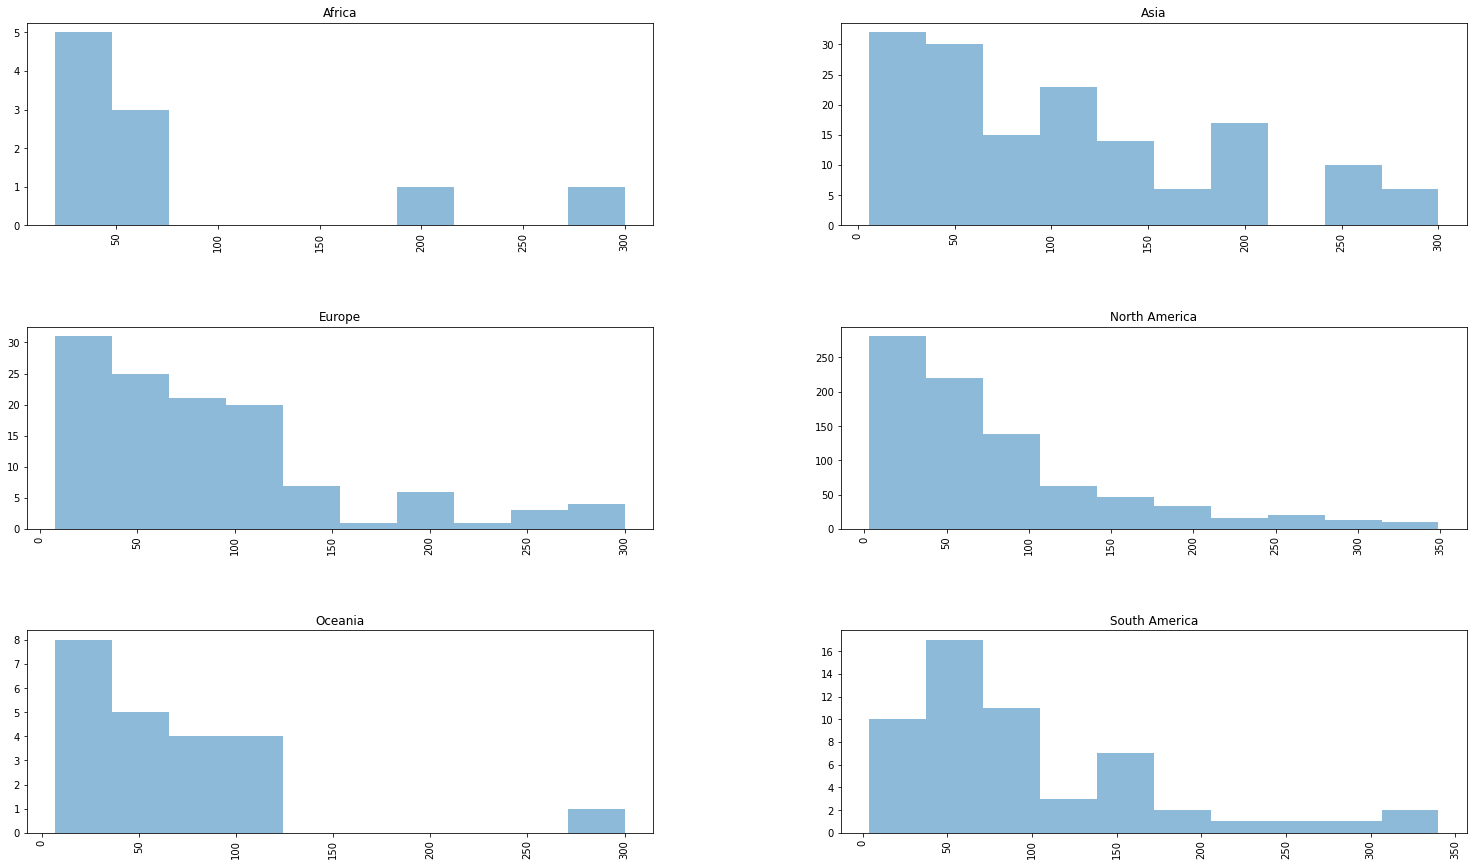

In [516]:
ax = df_partial.hist(alpha=0.5, column='total_laid_off', by='continent', figsize=(25,15))

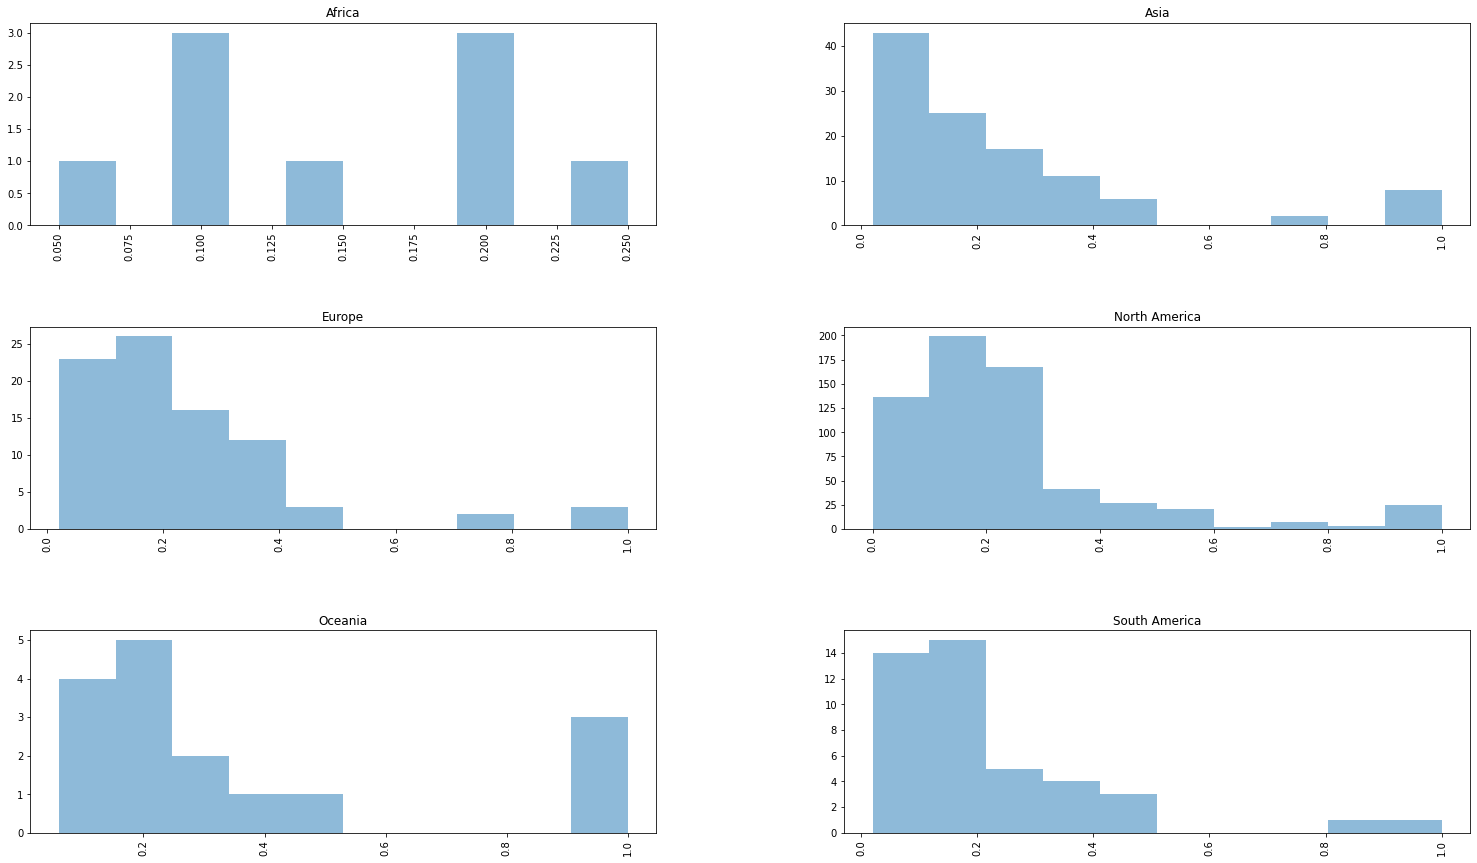

In [517]:
ax = df_partial.hist(alpha=0.5, column='percentage_laid_off', by='continent', figsize=(25,15))

Estos histogramas nos permiten ver que ni los datos de total ni los porcentajes de personas despedidas siguen una forma normal ya que ni de lejos se parecen las distribuiciones a la típica campana de Gauss.

Por otra parte, en el caso de los totales, la presencia de lo que parecen ser *outliers* en algunos continentes, no nos permite analizar cómo se distribuyen realmente la mayoría de los datos.

Pasemos pues a analizar mediante *boxplots*:

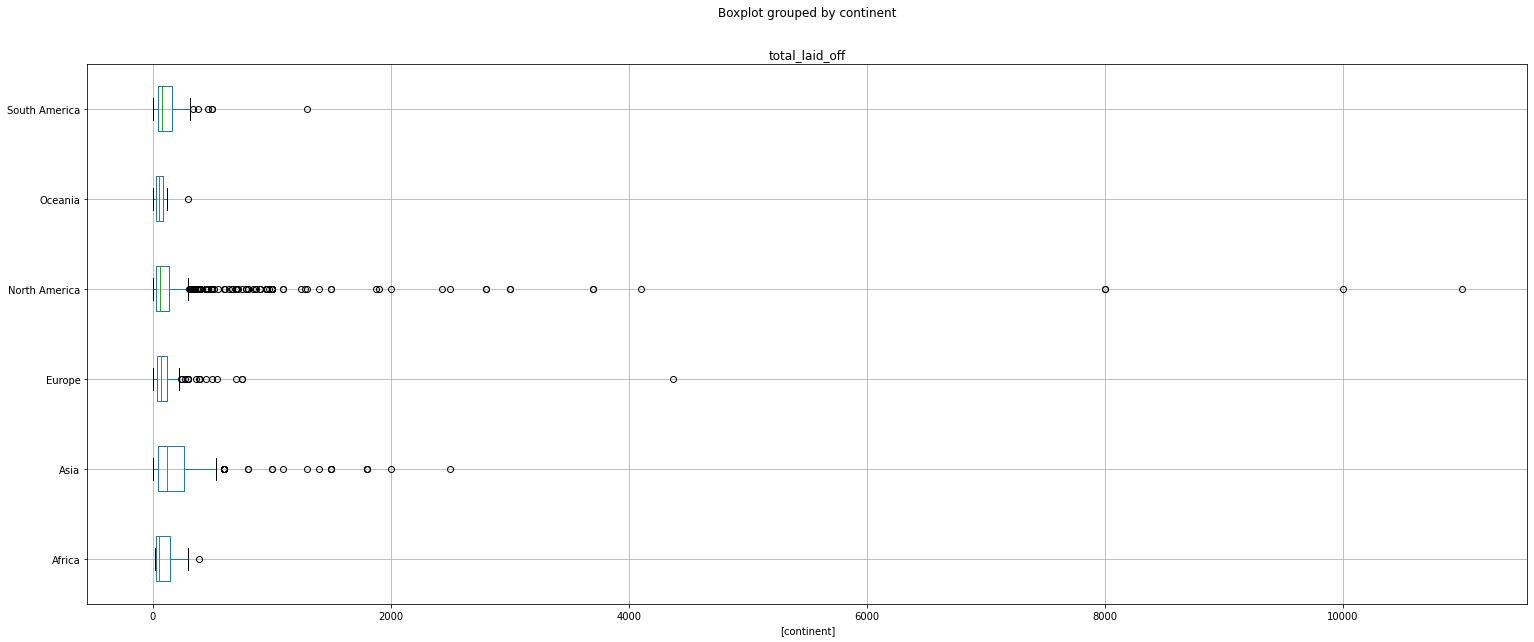

In [518]:
boxplot = df.boxplot(column=['total_laid_off'], by=['continent'], vert=False, figsize=(25,10))

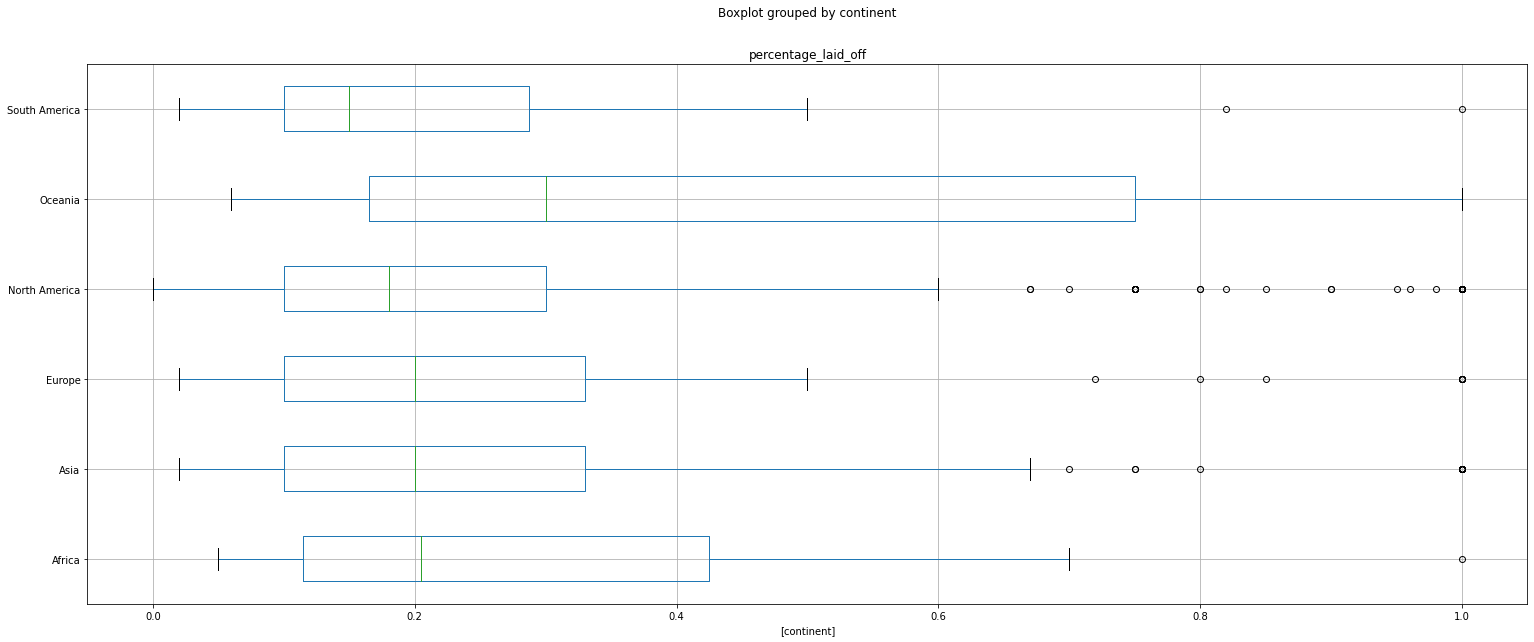

In [519]:
boxplot = df.boxplot(column=['percentage_laid_off'], by=['continent'], vert=False, figsize=(25,10))

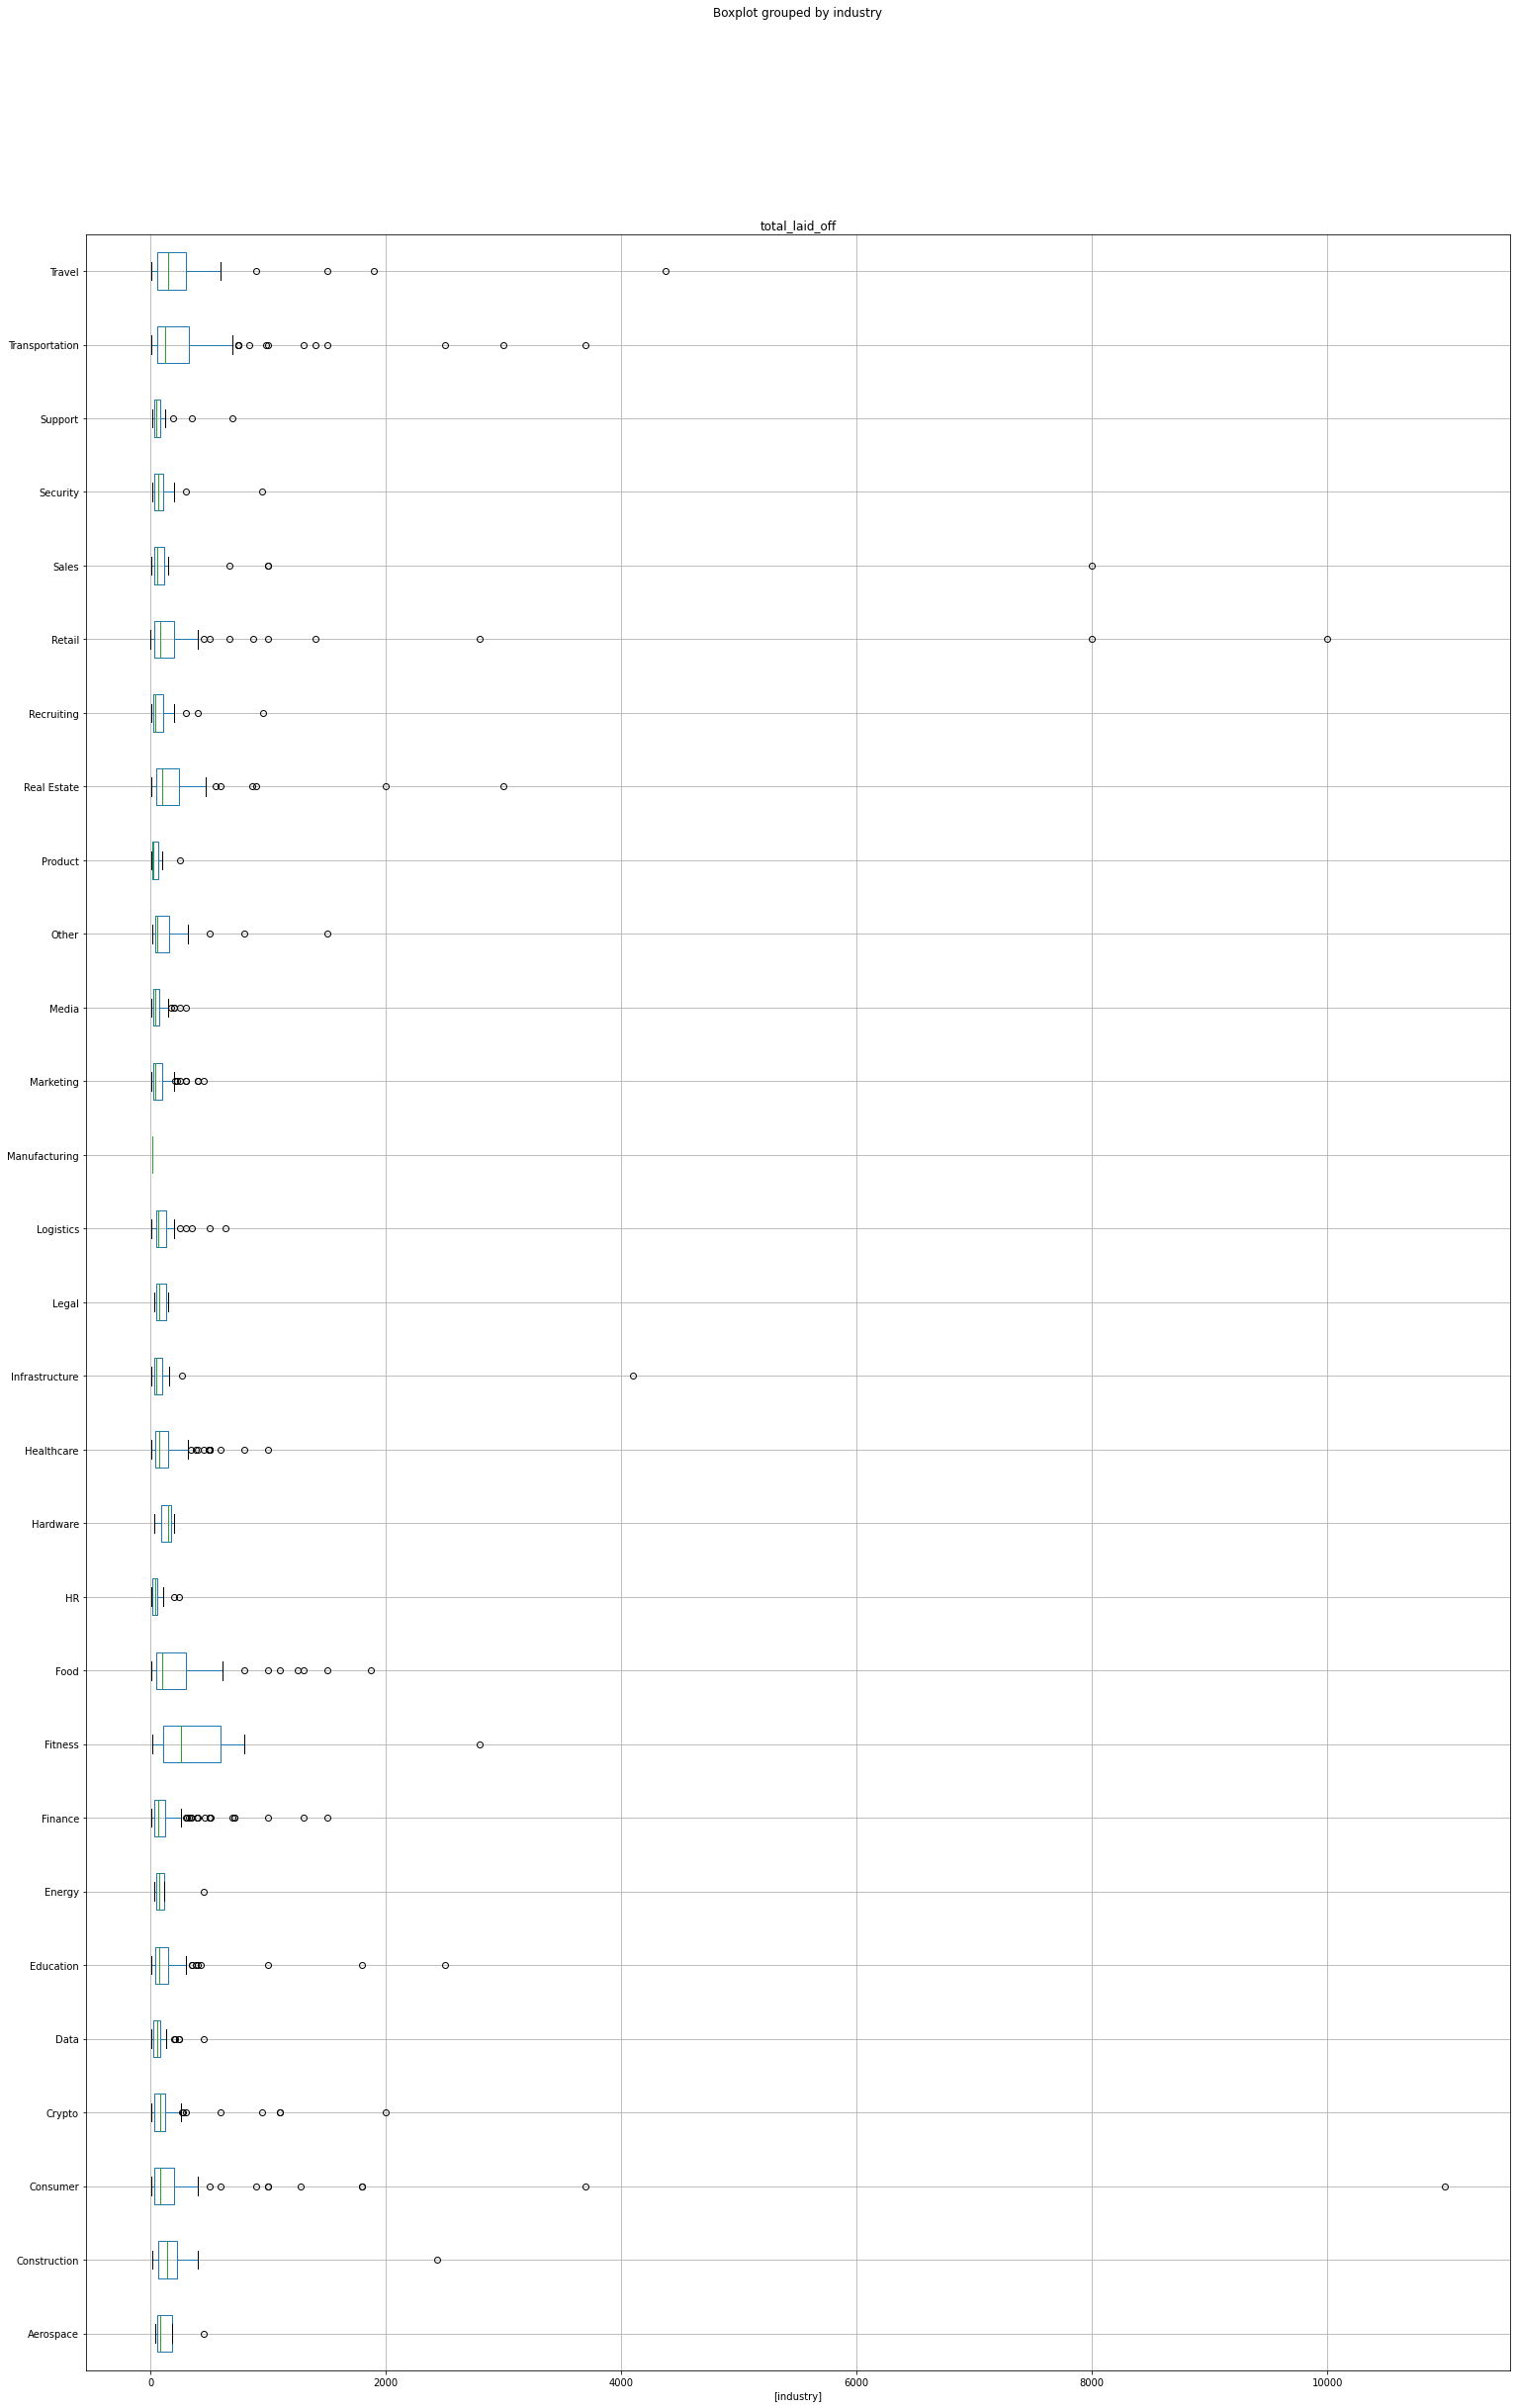

In [520]:
boxplot = df.boxplot(column=['total_laid_off'], by=['industry'], vert=False, figsize=(25,40))

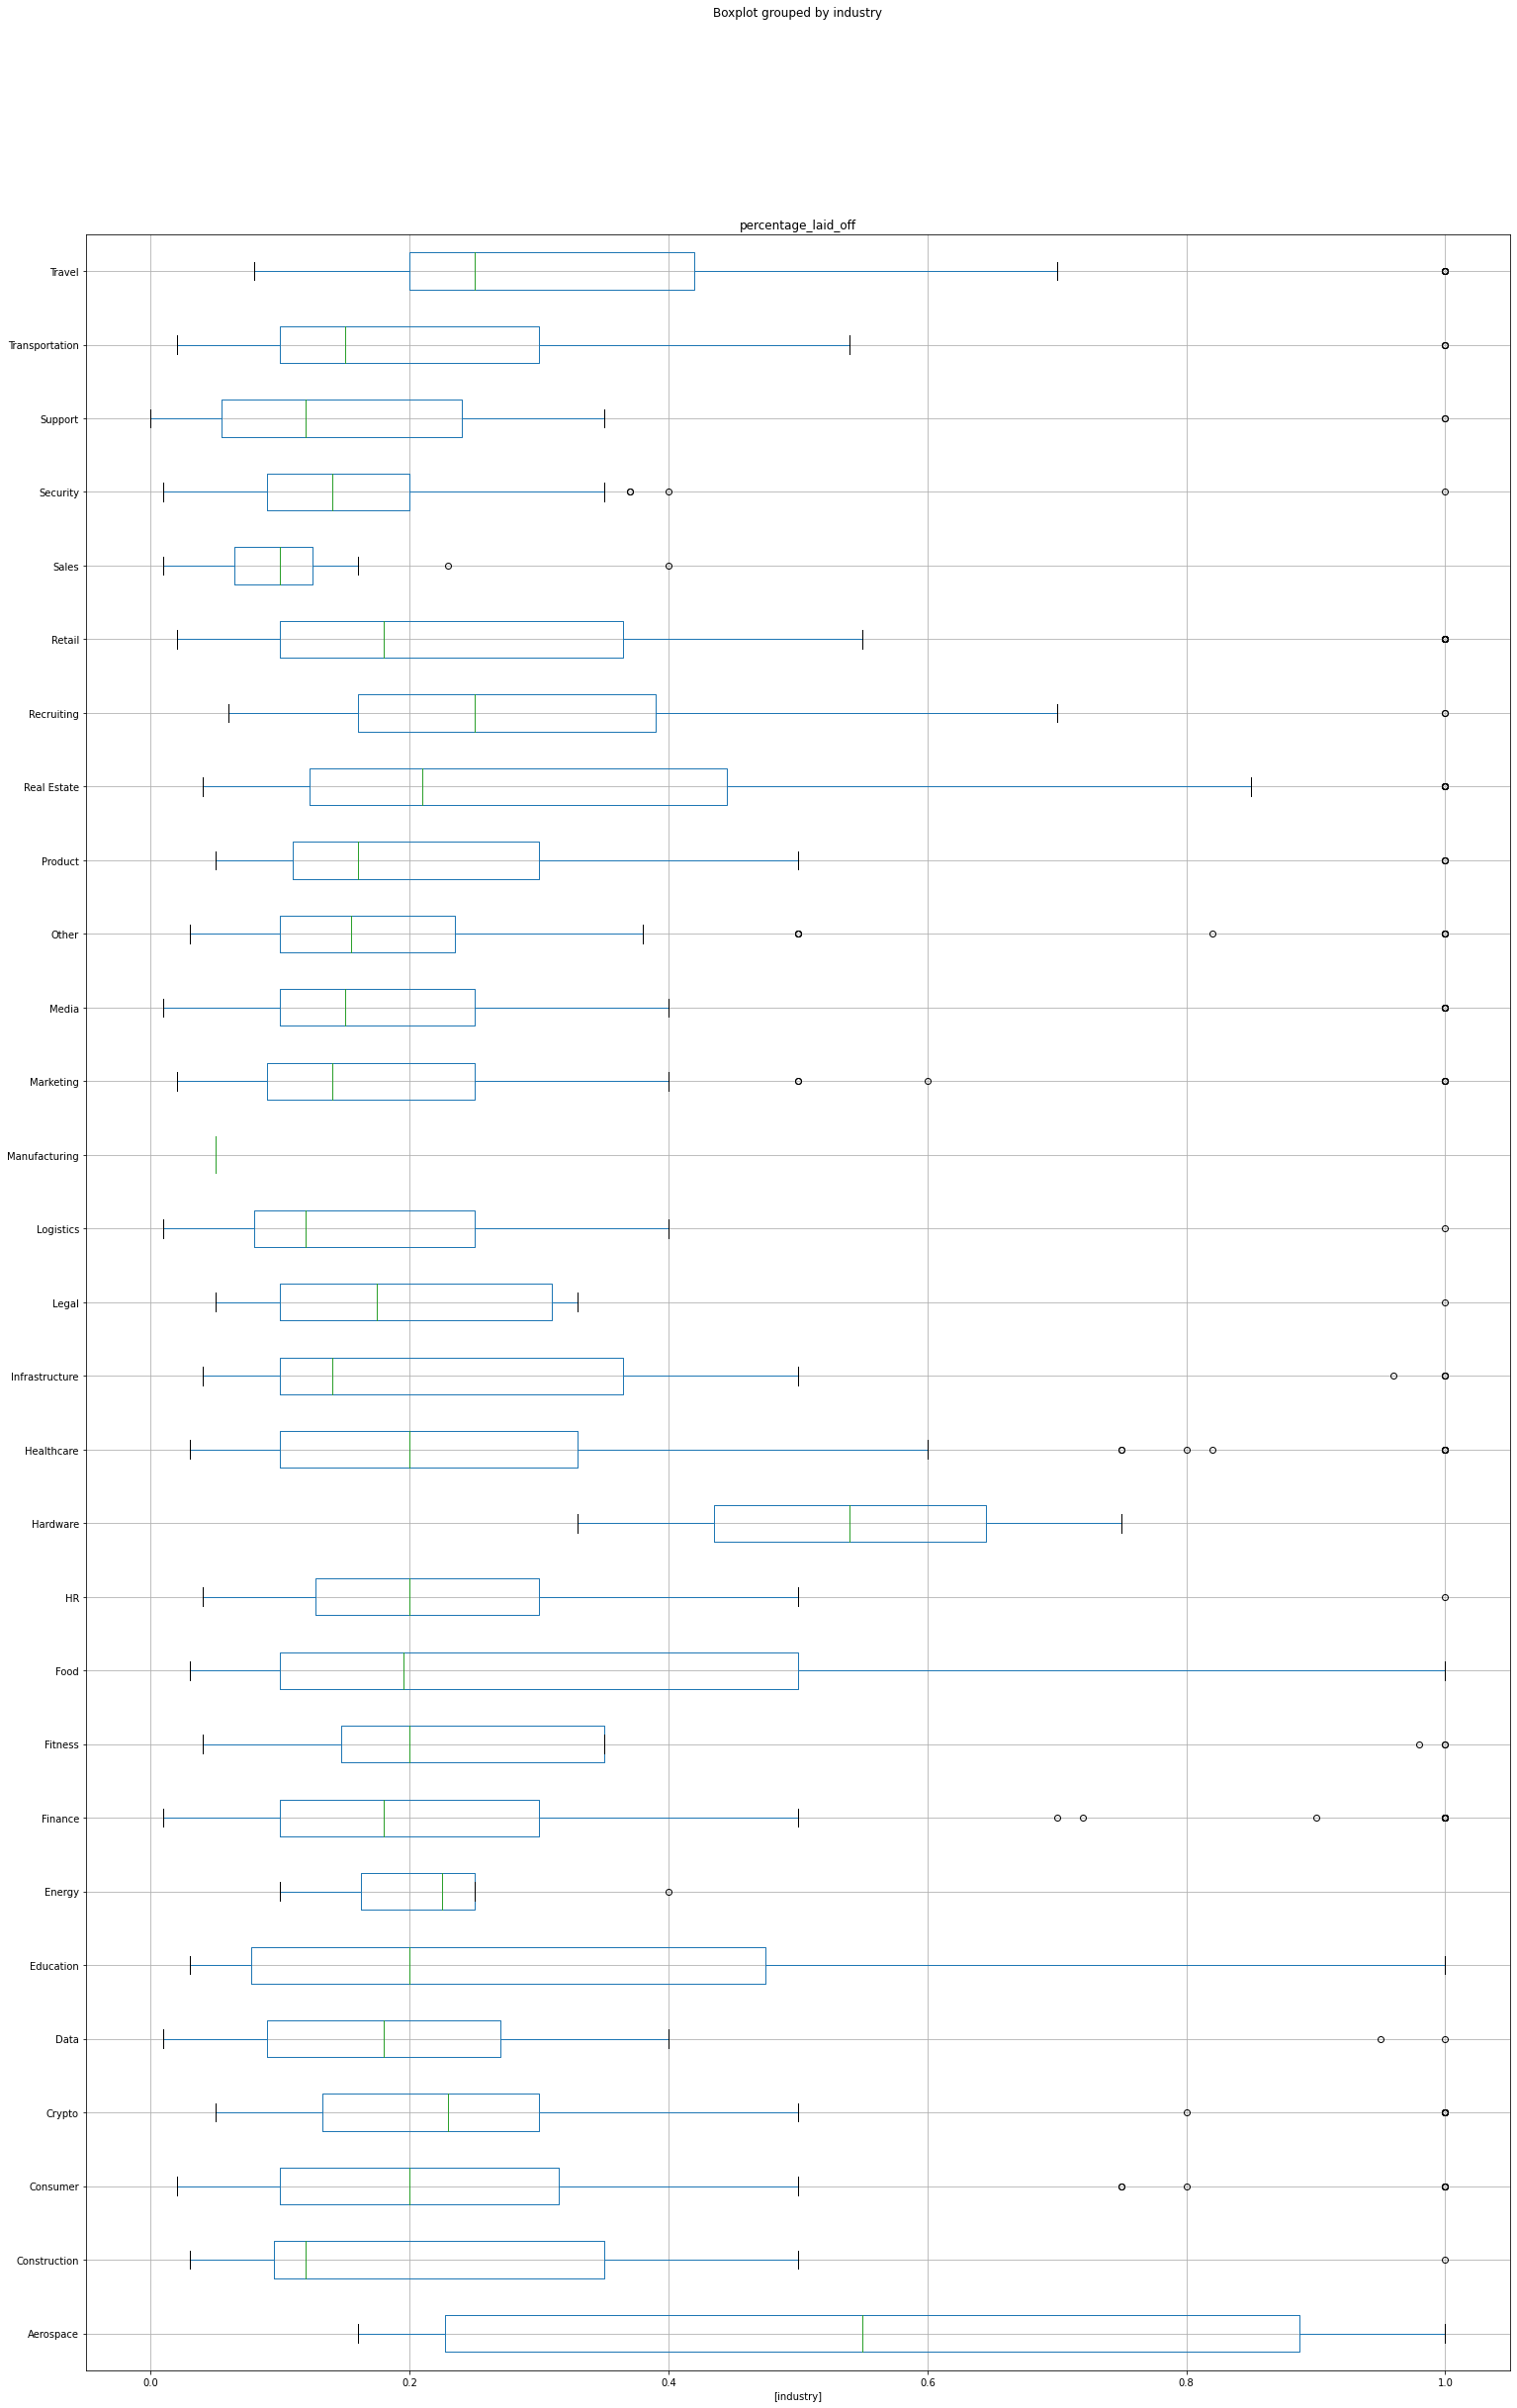

In [521]:
boxplot = df.boxplot(column=['percentage_laid_off'], by=['industry'], vert=False, figsize=(25,40))

Viendo los gráficos *boxplot* podemos ver que hay muchos *outliers*

Podemos ver en los gráficos de porcentajes que hay muchos casos de 100% de empleados despedidos, lo cual indica un cierre total del negocio.

Vamos a ver cuál es el impacto de los cierres en los datos

In [522]:
df_partial = df[df.percentage_laid_off < 1.0]
df_partial.describe()

,total_laid_off,percentage_laid_off,funds_raised,year,month,day
count,979.000000,1212.000000,1129.000000,1212.000000,1212.000000,1212.000000
mean,226.678243,0.205951,782.162604,2021.410066,6.754125,14.503300
std,709.088954,0.153935,5498.648838,0.987618,3.125074,9.007337
min,3.000000,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,35.000000,0.100000,63.000000,2020.000000,4.000000,7.000000
50%,75.000000,0.160000,169.000000,2022.000000,6.000000,14.000000
75%,160.000000,0.270000,438.000000,2022.000000,10.000000,22.000000
max,11000.000000,0.980000,121900.000000,2023.000000,12.000000,31.000000


In [523]:
df_partial.shape

(1212, 15)

Contrariamente a lo que pudiera intuirse, la media de trabajadores despedidos, al eliminar los cierres totales, aumenta de 202 a 226. Esto indica que los cierres totales se han producido en empresas de tamaño pequeño y mediano lo que, por otra parte, es un escenario habitual.

Mostremos un par de gráficos para corroborar que los valores *outliers* no han variado, no al menos significativamente.

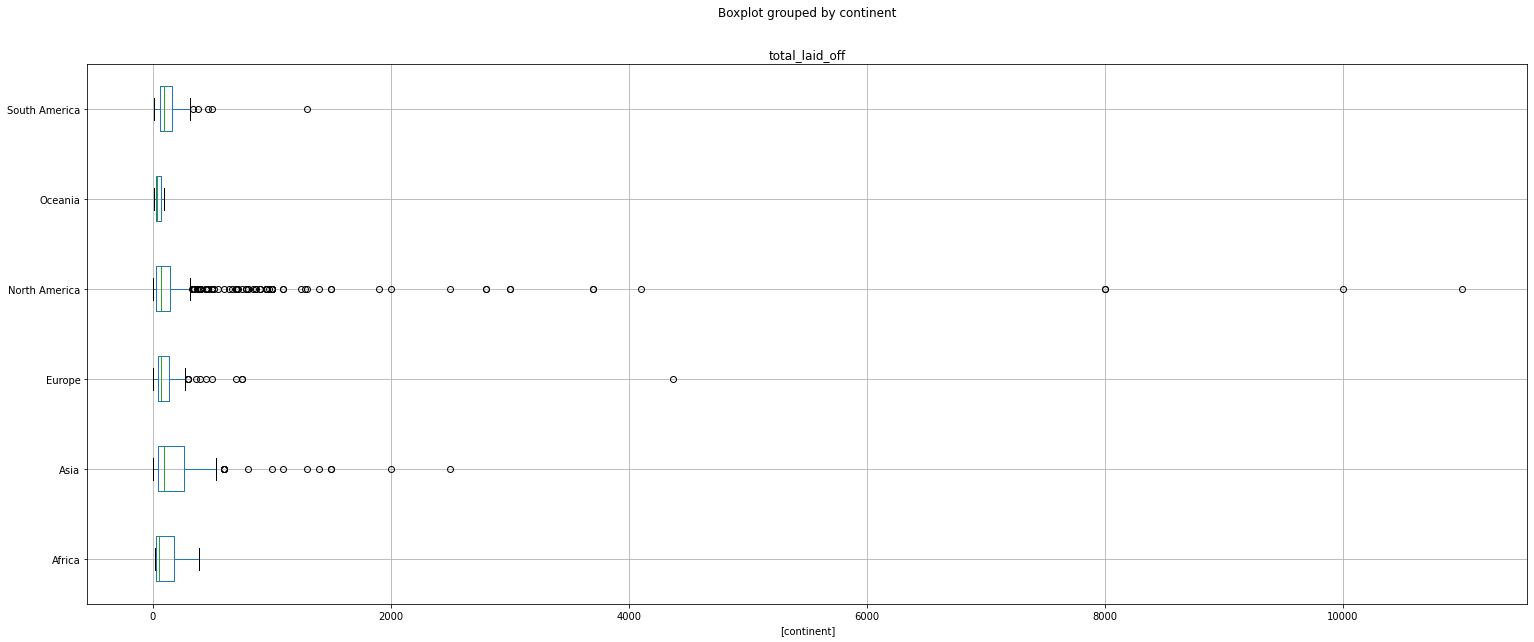

In [524]:
boxplot = df_partial.boxplot(column=['total_laid_off'], by=['continent'], vert=False, figsize=(25,10))

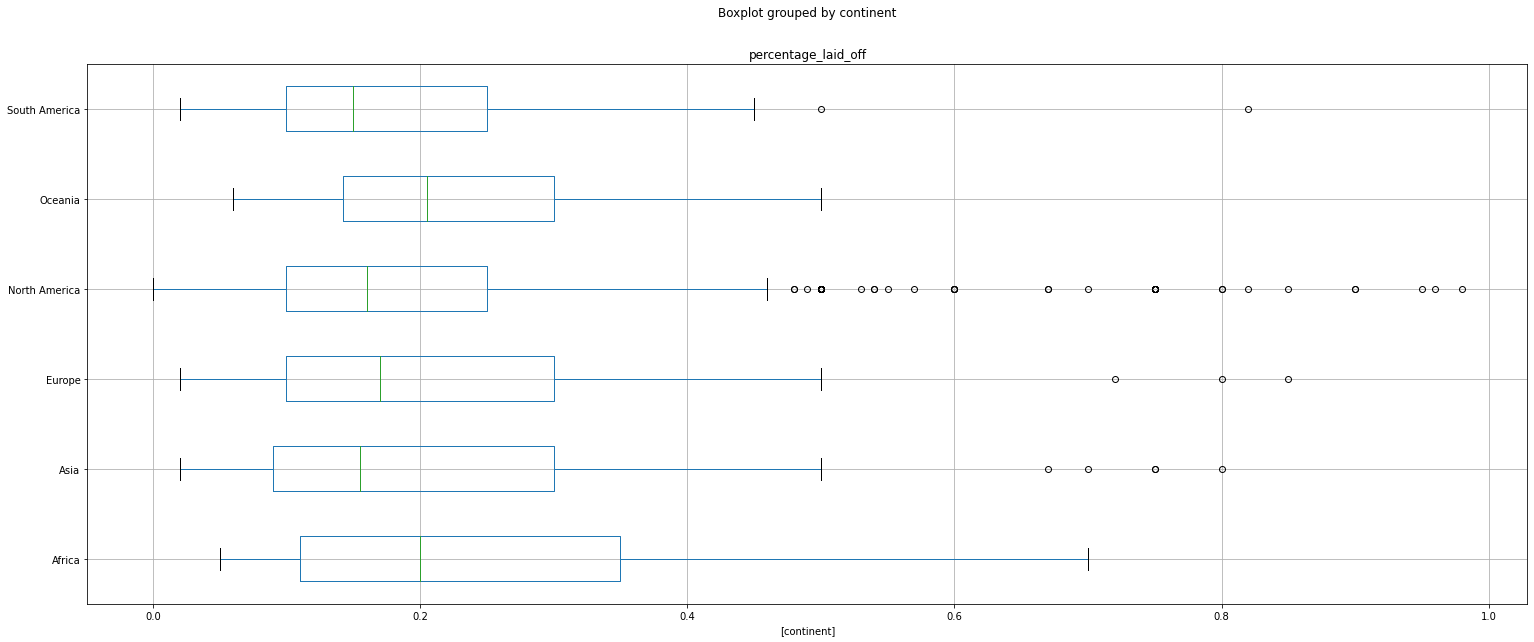

In [525]:
boxplot = df_partial.boxplot(column=['percentage_laid_off'], by=['continent'], vert=False, figsize=(25,10))

Veámos un *boxplot* global para buscar un punto de referencia general con el que hacer otros cálculos y gráficos.

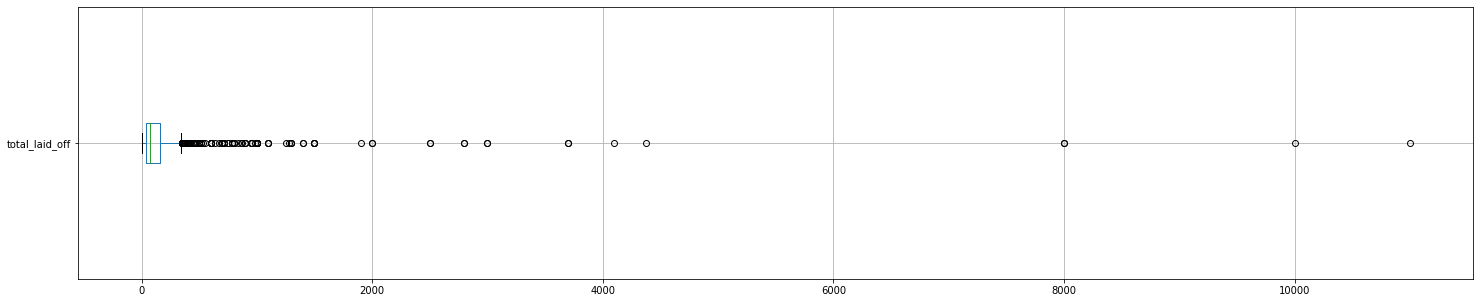

In [526]:
boxplot = df_partial.boxplot(column=['total_laid_off'], vert=False, figsize=(25,5))

Dado que seguimos observando un alto número de *outliers* con valores muy altos para los continentes y para el global, es importante ver el porcentaje de valores fuera de norma para decidir si los eliminamos o no a la hora de calcular los valores a imputar en los campos nulos.

Viendo el gráfico global, vemos que los valores denominados *outliers* se establecen cercanos a 350 (no es necesario ser rigurosos), así que utilizaremos ese valor como frontera. El objetivos es, aún cuando las distribuciones no son normales, aplicar unos valores medios no distorsionados por los valores extremos para los casos desconocidos.

Nota: partiremos del conjunto con todos los datos, sin haber eliminado los despidos completos por cierre.

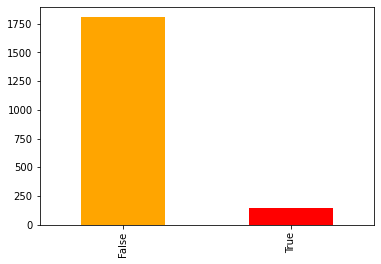

In [527]:
df_partial = df.copy()
df_partial['total_laid_off_outlier'] = np.where(df_partial['total_laid_off'] > 350, True, False)

# Creamos la representación gráfica, utilizando colores representativos
colors = ['orange', 'red']
df_partial['total_laid_off_outlier'].value_counts().plot(kind='bar', color=colors);

In [528]:
df_partial = df_partial[df_partial.total_laid_off < 350.0]
df_partial.describe()

,total_laid_off,percentage_laid_off,funds_raised,year,month,day
count,1200.000000,893.000000,1119.000000,1200.000000,1200.000000,1200.000000
mean,85.169167,0.235156,866.484143,2021.321667,6.513333,14.926667
std,73.459518,0.216162,7415.584543,0.997844,3.003999,9.238457
min,3.000000,0.000000,0.000000,2020.000000,1.000000,1.000000
25%,30.000000,0.100000,46.000000,2020.000000,4.000000,7.000000
50%,60.000000,0.180000,133.000000,2022.000000,6.000000,14.000000
75%,110.000000,0.300000,350.500000,2022.000000,9.000000,23.000000
max,349.000000,1.000000,121900.000000,2023.000000,12.000000,31.000000


Podemos ver que, ahora sí, la media de despidos ha bajado drásticamente de 202 a 86. Con este conjunto de datos buscaremos los valores medios a asignar, tomando la decisión de hacerlo por continente o por industria (se descarta por industria y continente).

In [529]:
df.groupby('continent')[['total_laid_off', 'percentage_laid_off']].describe()

total_laid_off                                             \
                       count        mean         std   min   25%    50%   
continent                                                                 
Africa                  11.0  110.454545  129.659063  20.0  28.5   54.0   
Asia                   195.0  260.158974  396.475855   6.0  47.5  120.0   
Europe                 129.0  151.286822  399.736206   8.0  40.0   70.0   
North America          934.0  206.057816  705.925814   3.0  30.0   64.0   
Oceania                 22.0   67.227273   62.128846   7.0  30.0   54.0   
South America           60.0  143.400000  192.618724   4.0  50.0   81.5   

                               percentage_laid_off                            \
                  75%      max               count      mean       std   min   
continent                                                                      
Africa         143.00    391.0                16.0  0.303750  0.260253  0.05   
Asia           265.00   2500.0               173.0  0.302601  0.300249  0.02   
Europe         120.00   4375.0               113.0  0.264425  0.229603  0.02   
North America  140.00  11000.0               937.0  0.260910  0.253926  0.00   
Oceania         86.25    300.0                27.0  0.429259  0.361098  0.06   
South America  160.00   1300.0                50.0  0.209200  0.189982  0.02   

                                          
                 25%    50%     75%  max  
continent                                 
Africa         0.115  0.205  0.4250  1.0  
Asia           0.100  0.200  0.3300  1.0  
Europe         0.100  0.200  0.3300  1.0  
North America  0.100  0.180  0.3000  1.0  
Oceania        0.165  0.300  0.7500  1.0  
South America  0.100  0.150  0.2875  1.0

In [530]:
df.groupby('industry')[['total_laid_off', 'percentage_laid_off']].describe()

total_laid_off                                                \
                        count        mean          std   min     25%    50%   
industry                                                                      
Aerospace                 4.0  165.250000   192.068347  40.0   62.50   85.0   
Construction             11.0  348.454545   701.160091  13.0   65.00  140.0   
Consumer                 70.0  422.600000  1397.704468   5.0   36.25   83.0   
Crypto                   50.0  193.880000   361.394953   9.0   34.75   80.0   
Data                     42.0   76.857143    83.174390  10.0   25.50   62.0   
Education                62.0  186.677419   397.075653   4.0   40.00   74.5   
Energy                    6.0  133.666667   158.481124  30.0   49.75   77.5   
Finance                 179.0  125.865922   197.076025   5.0   32.00   63.0   
Fitness                  19.0  457.263158   628.989387  17.0  110.00  262.0   
Food                     80.0  251.125000   357.024035   4.0   50.00  100.0   
HR                       37.0   50.945946    49.088891   5.0   17.00   40.0   
Hardware                  3.0  128.000000    88.198639  30.0   91.50  153.0   
Healthcare               97.0  138.670103   175.243564   8.0   40.00   75.0   
Infrastructure           20.0  272.650000   902.943915   6.0   30.00   53.5   
Legal                     7.0   88.571429    48.880320  30.0   52.50   75.0   
Logistics                27.0  129.111111   154.358557  10.0   52.00   63.0   
Manufacturing             1.0   20.000000          NaN  20.0   20.00   20.0   
Marketing                86.0   76.174419    90.177106   4.0   24.00   45.5   
Media                    54.0   62.907407    65.149833   5.0   20.75   39.5   
Other                    47.0  143.829787   246.085556  13.0   40.00   60.0   
Product                  22.0   49.181818    54.799754   6.0   19.25   23.5   
Real Estate              71.0  232.661972   436.570333   6.0   48.50  100.0   
Recruiting               23.0  120.652174   207.463602   7.0   24.00   40.0   
Retail                  109.0  333.201835  1241.214428   3.0   36.00   80.0   
Sales                    26.0  457.884615  1563.363152  11.0   31.00   55.5   
Security                 42.0  101.476190   146.770974  13.0   30.00   69.5   
Support                  22.0  106.181818   151.541802  16.0   36.75   51.0   
Transportation           90.0  338.844444   604.392497   7.0   60.00  125.0   
Travel                   44.0  355.000000   722.250552  10.0   54.50  155.0   

                                percentage_laid_off                            \
                   75%      max               count      mean       std   min   
industry                                                                        
Aerospace       187.75    451.0                 4.0  0.565000  0.421782  0.16   
Construction    225.00   2434.0                11.0  0.260000  0.288756  0.03   
Consumer        200.00  11000.0                59.0  0.278983  0.258375  0.02   
Crypto          128.00   2000.0                66.0  0.300303  0.257258  0.05   
Data             80.00    450.0                41.0  0.215366  0.201880  0.01   
Education       150.00   2500.0                50.0  0.348200  0.342915  0.03   
Energy          114.25    450.0                 6.0  0.225000  0.103682  0.10   
Finance         124.00   1500.0               173.0  0.246185  0.232882  0.01   
Fitness         600.00   2800.0                20.0  0.315500  0.306431  0.04   
Food            300.00   1877.0                70.0  0.355714  0.337822  0.03   
HR               60.00    245.0                34.0  0.242647  0.179331  0.04   
Hardware        177.00    201.0                 2.0  0.540000  0.296985  0.33   
Healthcare      150.00   1000.0                98.0  0.275816  0.242886  0.03   
Infrastructure   99.50   4100.0                23.0  0.299565  0.342961  0.04   
Legal           130.00    150.0                 6.0  0.305000  0.356581  0.05   
Logistics       130.00    64

In [531]:
df.groupby('continent')[['total_laid_off', 'percentage_laid_off']].describe()

total_laid_off                                             \
                       count        mean         std   min   25%    50%   
continent                                                                 
Africa                  11.0  110.454545  129.659063  20.0  28.5   54.0   
Asia                   195.0  260.158974  396.475855   6.0  47.5  120.0   
Europe                 129.0  151.286822  399.736206   8.0  40.0   70.0   
North America          934.0  206.057816  705.925814   3.0  30.0   64.0   
Oceania                 22.0   67.227273   62.128846   7.0  30.0   54.0   
South America           60.0  143.400000  192.618724   4.0  50.0   81.5   

                               percentage_laid_off                            \
                  75%      max               count      mean       std   min   
continent                                                                      
Africa         143.00    391.0                16.0  0.303750  0.260253  0.05   
Asia           265.00   2500.0               173.0  0.302601  0.300249  0.02   
Europe         120.00   4375.0               113.0  0.264425  0.229603  0.02   
North America  140.00  11000.0               937.0  0.260910  0.253926  0.00   
Oceania         86.25    300.0                27.0  0.429259  0.361098  0.06   
South America  160.00   1300.0                50.0  0.209200  0.189982  0.02   

                                          
                 25%    50%     75%  max  
continent                                 
Africa         0.115  0.205  0.4250  1.0  
Asia           0.100  0.200  0.3300  1.0  
Europe         0.100  0.200  0.3300  1.0  
North America  0.100  0.180  0.3000  1.0  
Oceania        0.165  0.300  0.7500  1.0  
South America  0.100  0.150  0.2875  1.0

Dada la gran diferencia de datos que hay en el dataset entre Estados Unidos y el resto de continentes, utilizaremos la media por industria para asignar a los valores nulos

In [532]:
mymap = df.groupby('industry')[['total_laid_off', 'percentage_laid_off', 'funds_raised']].describe()


In [533]:

replace_function = \
    lambda x: round(mymap.loc[x.industry]['total_laid_off']['mean']) \
        if (pd.isnull(x.total_laid_off)) \
        else x.total_laid_off
df_temp = df.apply(replace_function, axis=1)
df['total_laid_off'] = df_temp

replace_function = \
    lambda x: round(mymap.loc[x.industry]['percentage_laid_off']['mean'],2) \
        if (pd.isnull(x.percentage_laid_off)) \
        else x.percentage_laid_off
df_temp = df.apply(replace_function, axis=1)
df['percentage_laid_off'] = df_temp

replace_function = \
    lambda x: round(mymap.loc[x.industry]['funds_raised']['mean']) \
        if (pd.isnull(x.funds_raised)) \
        else x.funds_raised
df_temp = df.apply(replace_function, axis=1)
df['funds_raised'] = df_temp

df.isnull().sum()


company                0
location               0
industry               0
total_laid_off         0
percentage_laid_off    0
date                   0
stage                  4
country                0
funds_raised           0
year                   0
month                  0
day                    0
country_code           0
continent_code         0
continent              0
dtype: int64

In [534]:
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,month,day,country_code,continent_code,continent
0,Ola,Bengaluru,Transportation,200.0,0.22,2023-01-13,Series J,India,5000.0,2023,1,13,IN,AS,Asia
1,Definitive Healthcare,Boston,Healthcare,55.0,0.06,2023-01-12,IPO,United States,349.0,2023,1,12,US,NA,North America
2,SmartNews,Tokyo,Media,120.0,0.13,2023-01-12,Series F,United States,410.0,2023,1,12,US,NA,North America
3,Lending Club,SF Bay Area,Finance,225.0,0.14,2023-01-12,IPO,United States,392.0,2023,1,12,US,NA,North America
4,Life360,SF Bay Area,Consumer,423.0,0.14,2023-01-12,IPO,United States,158.0,2023,1,12,US,NA,North America


Podemos ver cómo la compañía "Ola" que tenía un valor nulo en el porcentaje, ahora tienen el 22% que es la media de porcentajes de la industría "Transportation", como podemos ver en la siguiente línea:

In [535]:
value = mymap.loc['Transportation']['percentage_laid_off']['mean']
f"{value:.0%}"

'22%'

In [536]:
df.to_csv('layoffs_processed.csv')

<h2>Resumen</h2>

Una vez analizado los datos, hemos creado nuevos campos de año, mes y día, para procesar las fechas de los despidos de forma agrupada. También hemos hecho lo propio con los países, donde hemos creado una nueva columna con el continente. Esto nos permitirá trabajar de forma más eficiente con los datos en próximos pasos.

También hemos eliminado los valores nulos, que hemos visto que eran muchos. Para la única fila que tenía una fecha nula, hemos seguido un proceso de análisis del dato, yendo a buscar información real de la fecha que, con suerte, hemos podido deducir a partir de información disponible públicamente.

Para informar los valores númericos nulos referentes al total y porcentaje de personas despedidas así como los fondos necesarios para llevar a cabo los despidos, hemos analizado gráficamente los datos y hemos llegado a la conclusión de poblar el juego de datos con la media de esos valores sacada de las agrupaciones de los valores por industria, descartando la agrupación por continentes.